In [1]:
import os 
#import time
import xarray as xr 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import cartopy.feature as cf

import scipy.stats

from matplotlib.backends.backend_pdf import PdfPages

#### Load input data

In [2]:
epoch = 181
mode = 'val'  # 'train', 'val', 'test'
model = 'Full_Images_200_epochs_Charbonier'

path_dir_input = os.path.join(os.getcwd(), '..', 'data', 'ERA5', 'preprocessed_separate', mode)
path_dir_target = os.path.join(os.getcwd(), '..', 'data', 'CERRA', 'preprocessed_separate', mode)

path_dir_output = os.path.join(os.getcwd(), '..', 'AirPollution_Run', model, 'output', 'data', 'valid')

print('Loading input data')
ds_input = xr.open_dataset(os.path.join(path_dir_input, f'{mode}_input_data_cams_global_daily_avg.nc'))
ds_target = xr.open_dataset(os.path.join(path_dir_target, f'{mode}_target_data_cams_europe_regional_daily_avg.nc'))
ds_output = xr.open_dataset(os.path.join(path_dir_output, f'reconstructed_y_hat_s_{epoch:04d}.nc'))

Loading input data


In [3]:
ds_input

<xarray.Dataset>
Dimensions:    (time: 130, latitude: 106, longitude: 176)
Coordinates:
  * time       (time) datetime64[ns] 2024-01-30 2024-01-18 ... 2024-09-30
  * latitude   (latitude) float64 72.0 71.6 71.2 70.8 ... 31.2 30.8 30.4 30.0
  * longitude  (longitude) float64 -25.0 -24.6 -24.2 -23.8 ... 44.2 44.6 45.0
Data variables:
    pm2p5      (time, latitude, longitude) float32 ...
    blh        (time, latitude, longitude) float32 ...
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
    d2m        (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-05-17T05:16 GRIB to CDM+CF via cfgrib-0.9.1...

In [4]:
ds_target

<xarray.Dataset>
Dimensions:     (time: 130, latitude: 420, longitude: 700)
Coordinates:
  * latitude    (latitude) float32 71.95 71.85 71.75 71.65 ... 30.25 30.15 30.05
    level       float32 ...
  * time        (time) datetime64[ns] 2024-01-30 2024-01-18 ... 2024-09-30
  * longitude   (longitude) float32 -24.95 -24.85 -24.75 ... 44.75 44.85 44.95
Data variables:
    pm2p5_conc  (time, latitude, longitude) float32 ...
Attributes:
    title:        PM25 Air Pollutant FORECAST at the Surface
    institution:  Data produced by Meteo France
    source:       Data from ENSEMBLE model
    history:      Model ENSEMBLE FORECAST
    FORECAST:     Europe, 20240101-20241231+[0H_21H]
    summary:      ENSEMBLE model hourly FORECAST of PM25 concentration at the...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)

In [5]:
ds_output

<xarray.Dataset>
Dimensions:     (time: 130, latitude: 420, longitude: 700)
Coordinates:
    level       float32 ...
  * time        (time) datetime64[ns] 2024-01-30 2024-01-18 ... 2024-09-30
  * latitude    (latitude) float32 71.95 71.85 71.75 71.65 ... 30.25 30.15 30.05
  * longitude   (longitude) float32 -24.95 -24.85 -24.75 ... 44.75 44.85 44.95
Data variables:
    pm2p5_conc  (time, latitude, longitude) float32 ...

#### Load DataArrays

In [6]:
in_input = ds_input["pm2p5"]*1e9
in_target = ds_target["pm2p5_conc"]
in_output = ds_output["pm2p5_conc"]

#### Open a PDF file

In [7]:
path_out = os.path.join(os.getcwd())
pdf = PdfPages(os.path.join(path_out, '..', 'Basics_statistics.pdf'))

#### Flat the data

In [8]:
in_input_flat = in_input.values.flatten()
in_target_flat = in_target.values.flatten()
in_output_flat = in_output.values.flatten()

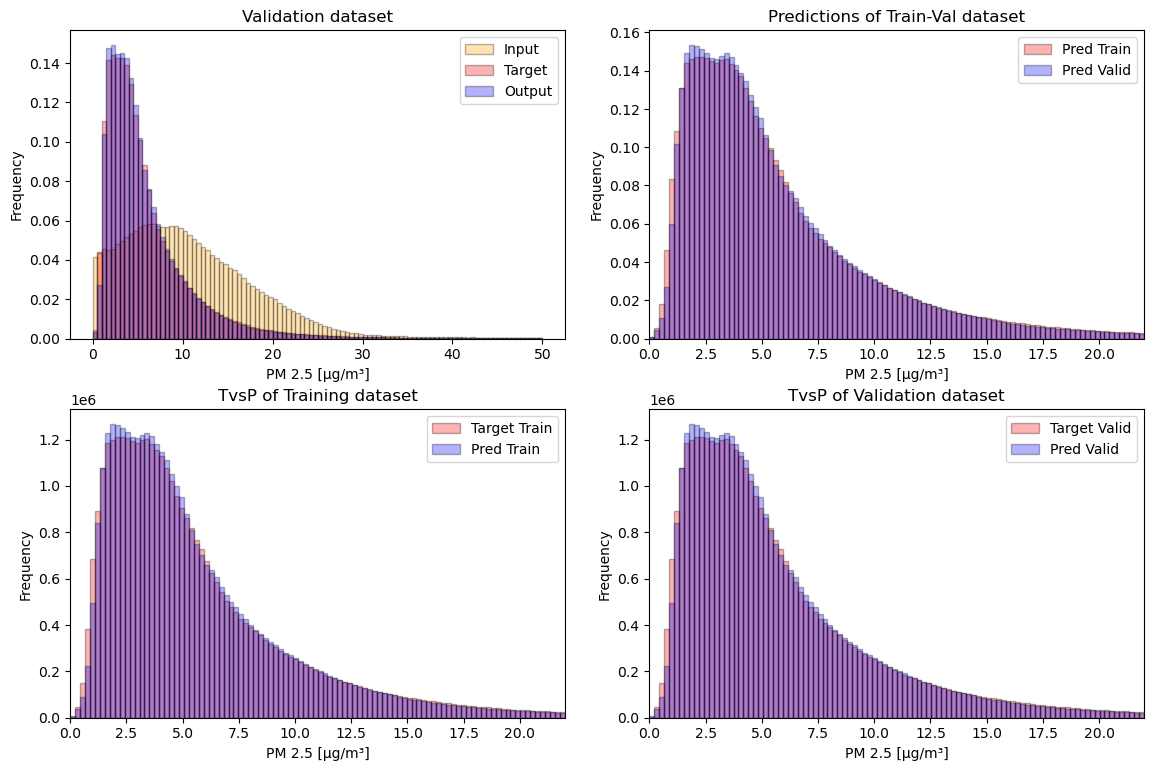

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
fig.tight_layout(pad=3.0)

#axes[0, 0].hist(input_train_flat, bins=100, alpha=0.7, color='green', label='Input', edgecolor='black', density=True)
axes[0, 0].hist(in_input_flat, bins=100, alpha=0.3, color='orange', label='Input', edgecolor='black', range=(0, 50), density=True)
axes[0, 0].hist(in_target_flat, bins=100, alpha=0.3, color='red', label='Target', edgecolor='black', range=(0, 50), density=True)
axes[0, 0].hist(in_output_flat, bins=100, alpha=0.3, color='blue', label='Output', edgecolor='black', range=(0, 50), density=True)
#axes[0, 0].set_xlim([0, 22])
axes[0, 0].set_title('Validation dataset')
axes[0, 0].set_xlabel('PM 2.5 [µg/m³]')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()


#axes[0, 1].hist(input_train_flat, bins=100, alpha=0.7, color='green', label='Input', edgecolor='black', density=True)
axes[0, 1].hist(in_target_flat, bins=100, alpha=0.3, color='red', label='Pred Train', edgecolor='black', range=(0, 22), density=True)
axes[0, 1].hist(in_output_flat, bins=100, alpha=0.3, color='blue', label='Pred Valid', edgecolor='black', range=(0, 22), density=True)
axes[0, 1].set_xlim([0, 22])
axes[0, 1].set_title('Predictions of Train-Val dataset')
axes[0, 1].set_xlabel('PM 2.5 [µg/m³]')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

#axes[1, 0].hist(input_train_flat, bins=100, alpha=0.7, color='green', label='Input', edgecolor='black')
axes[1, 0].hist(in_target_flat, bins=100, alpha=0.3, color='red', label='Target Train', edgecolor='black', range=(0, 22))
axes[1, 0].hist(in_output_flat, bins=100, alpha=0.3, color='blue', label='Pred Train', edgecolor='black', range=(0, 22))
axes[1, 0].set_xlim([0, 22])
axes[1, 0].set_title('TvsP of Training dataset')
axes[1, 0].set_xlabel('PM 2.5 [µg/m³]')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()

#axes[1, 1].hist(input_train_flat, bins=100, alpha=0.7, color='green', label='Input', edgecolor='black')
axes[1, 1].hist(in_target_flat, bins=100, alpha=0.3, color='red', label='Target Valid', edgecolor='black', range=(0, 22))
axes[1, 1].hist(in_output_flat, bins=100, alpha=0.3, color='blue', label='Pred Valid', edgecolor='black', range=(0, 22))
axes[1, 1].set_xlim([0, 22])
#axes[1, 1].set_ylim([0, 10000])
axes[1, 1].set_title('TvsP of Validation dataset')
axes[1, 1].set_xlabel('PM 2.5 [µg/m³]')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()

pdf.savefig()

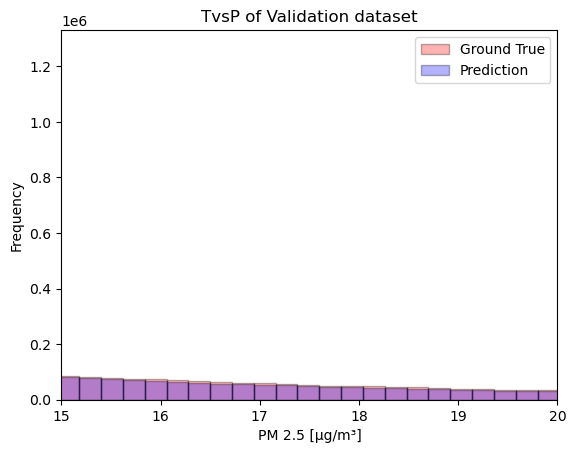

In [10]:
#plt.hist(input_train_flat, bins=100, alpha=0.7, color='green', label='Input', edgecolor='black')
plt.hist(in_target_flat, bins=100, alpha=0.3, color='red', label='Ground True', edgecolor='black', range=(0, 22))
plt.hist(in_output_flat, bins=100, alpha=0.3, color='blue', label='Prediction', edgecolor='black', range=(0, 22))
plt.xlim([15, 20])
#plt.ylim([0, 10000])
plt.title('TvsP of Validation dataset')
plt.xlabel('PM 2.5 [µg/m³]')
plt.ylabel('Frequency')
plt.legend()

pdf.savefig()

In [11]:
diff = in_output - in_target
diff_flat = diff.values.flatten()

In [12]:
print('Max diff train: ', np.nanmax(diff_flat))
print('Num values above 10: ', np.nansum(diff_flat>10))

Max diff train:  52.825798
Num values above 10:  49697


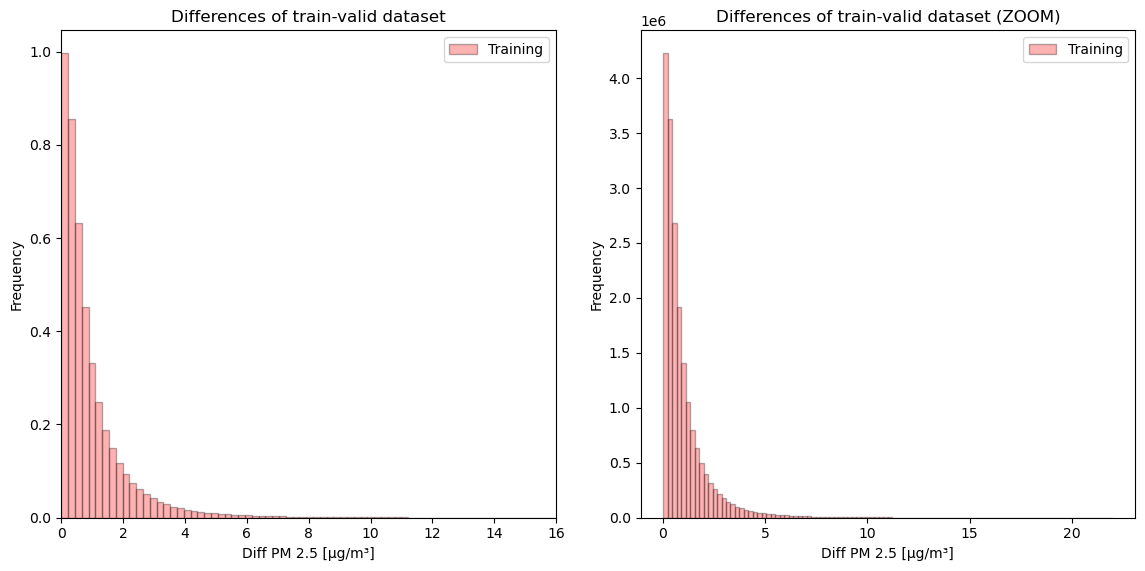

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.tight_layout(pad=3.0)

#axes[0].hist(input_train_flat, bins=100, alpha=0.7, color='green', label='Input', edgecolor='black')
axes[0].hist(diff_flat, bins=100, alpha=0.3, color='red', label='Training', edgecolor='black', range=(0, 22), density=True)
axes[0].set_xlim([0, 16])
axes[0].set_title('Differences of train-valid dataset')
axes[0].set_xlabel('Diff PM 2.5 [µg/m³]')
axes[0].set_ylabel('Frequency')
axes[0].legend()

#axes[1].hist(input_train_flat, bins=100, alpha=0.7, color='green', label='Input', edgecolor='black')
axes[1].hist(diff_flat, bins=100, alpha=0.3, color='red', label='Training', edgecolor='black', range=(0, 22))
#axes[1].set_xlim([10, 16])
#axes[1].set_ylim([0, 500])
axes[1].set_title('Differences of train-valid dataset (ZOOM)')
axes[1].set_xlabel('Diff PM 2.5 [µg/m³]')
axes[1].set_ylabel('Frequency')
axes[1].legend()

pdf.savefig()


Target events:  37384439
Predicion events:  37519607



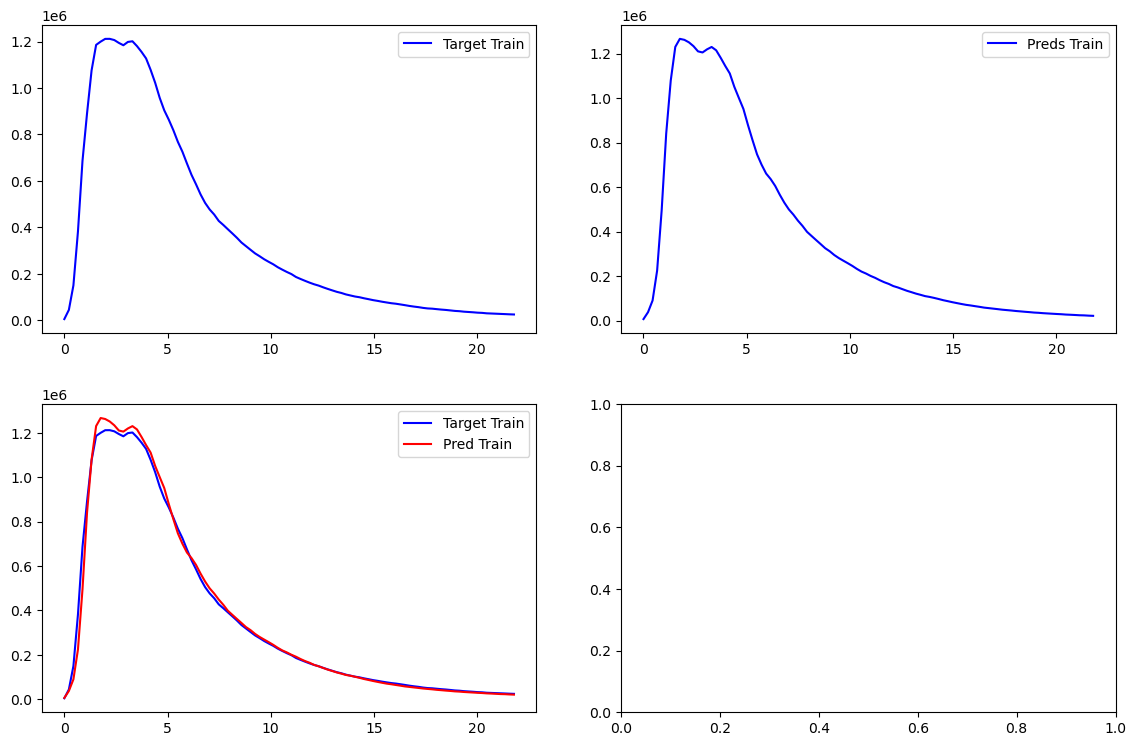

In [14]:
# Crear histogramas para ambos conjuntos de datos
target_hist, target_bins = np.histogram(in_target_flat, bins=100, range=(0, 22))
output_hist, output_bins = np.histogram(in_output_flat, bins=100, range=(0, 22))

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
fig.tight_layout(pad=3.0)

axes[0, 0].plot(target_bins[:-1], target_hist, color='blue', label='Target Train')
axes[0, 0].legend()

axes[0, 1].plot(output_bins[:-1], output_hist, color='blue', label='Preds Train')
axes[0, 1].legend()

axes[1, 0].plot(target_bins[:-1], target_hist, color='blue', label='Target Train')
axes[1, 0].plot(output_bins[:-1], output_hist, color='red', label='Pred Train')
axes[1, 0].legend()

pdf.savefig()

print()
print('Target events: ', np.sum(target_hist))
print('Predicion events: ', np.sum(output_hist))
print()

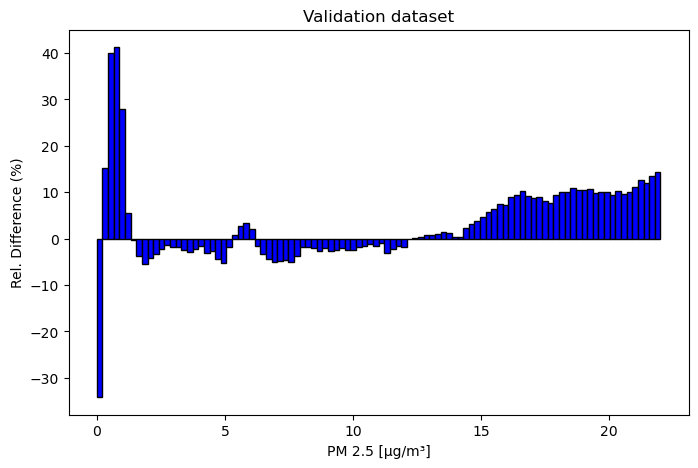


************************
Difference in the first bin:
Train: 
Value -34.17511902297661
************************


In [15]:
# Restar los histogramas
hist_diff_train = (target_hist - output_hist) / target_hist * 100

# Obtener los centros de los bins para el eje x
bin_centers_target = 0.5 * (target_bins[:-1] + target_bins[1:])

# Crear figura
plt.figure(figsize=(8, 5))
plt.bar(bin_centers_target, hist_diff_train, width=np.diff(target_bins), color='blue', edgecolor='black')

# Personalización
plt.title('Validation dataset')
plt.xlabel('PM 2.5 [µg/m³]')
plt.ylabel('Rel. Difference (%)')

# Guardar y mostrar
pdf.savefig()
plt.show()

print()
print('************************')
print('Difference in the first bin:')
print('Train: ')
print('Value', hist_diff_train[0])
print('************************')



In [16]:
stats = scipy.stats.spearmanr(target_hist, output_hist, axis=0, nan_policy='propagate')

print('Training dataset:')
print('Correlation: ', stats[0])
print('p-value: ', stats[1])

Training dataset:
Correlation:  0.9978517851785177
p-value:  8.045298318064394e-118


In [17]:
percentiles = np.arange(1, 100, 0.1)
#percentiles = np.arange(1, 100, 1)

print('Training Data')

print('Input')
input_train_percentil = np.nanpercentile(in_input_flat, percentiles)
print('Target')
targets_train_percentil = np.nanpercentile(in_target_flat, percentiles)
print('Prediction')
preds_train_percentil = np.nanpercentile(in_output_flat, percentiles)

Training Data
Input
Target
Prediction


In [18]:
print('Last percetil:')
print('Training target: ', targets_train_percentil[-1])
print('Training prediction: ', preds_train_percentil[-1])

Last percetil:
Training target:  62.390686050415525
Training prediction:  53.514786342639184


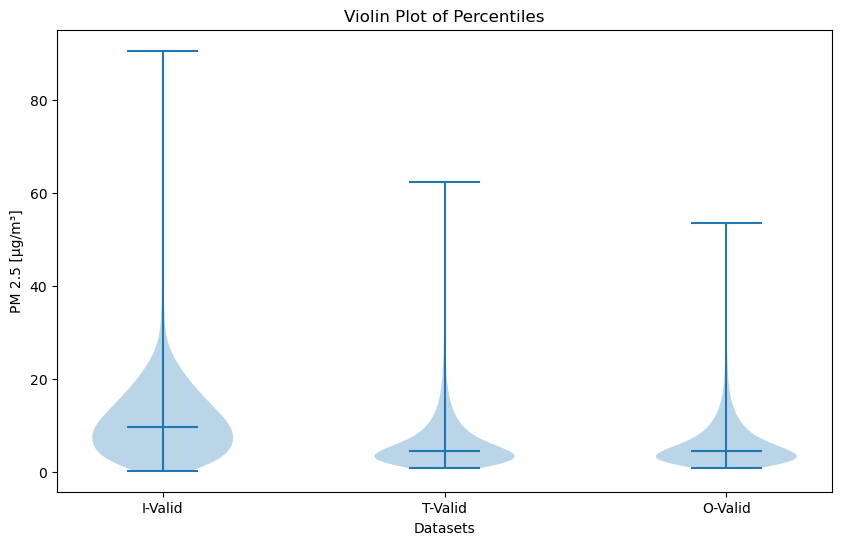

In [19]:
# Crear el Violin Plot
plt.figure(figsize=(10, 6))
plt.violinplot([input_train_percentil, targets_train_percentil, preds_train_percentil], showmedians=True)

# Añadir etiquetas y título
plt.xticks([1, 2, 3], ['I-Valid', 'T-Valid', 'O-Valid'])
plt.xlabel('Datasets')
plt.ylabel('PM 2.5 [µg/m³]')
plt.title('Violin Plot of Percentiles')

pdf.savefig()

# Mostrar el gráfico
plt.show()

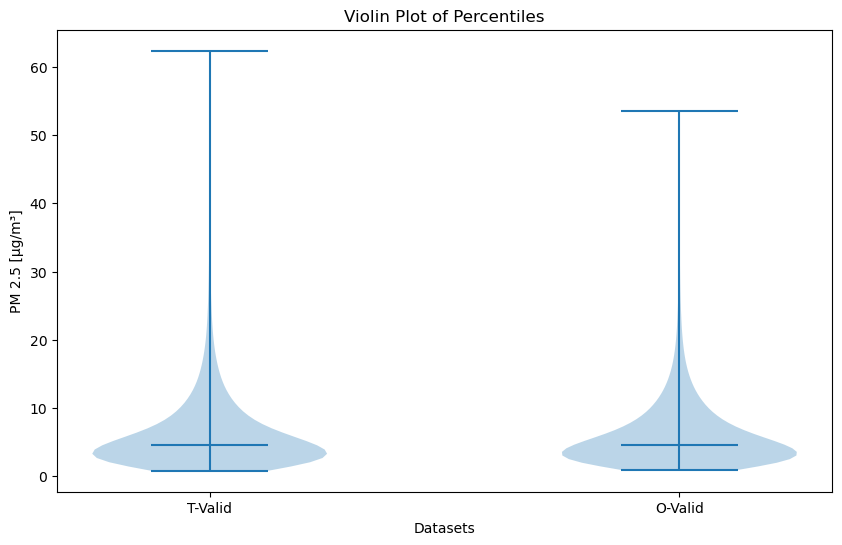

In [20]:
# Crear el Violin Plot
plt.figure(figsize=(10, 6))
plt.violinplot([targets_train_percentil, preds_train_percentil], showmedians=True)

# Añadir etiquetas y título
plt.xticks([1, 2], ['T-Valid', 'O-Valid'])
plt.xlabel('Datasets')
plt.ylabel('PM 2.5 [µg/m³]')
plt.title('Violin Plot of Percentiles')

pdf.savefig()

# Mostrar el gráfico
plt.show()

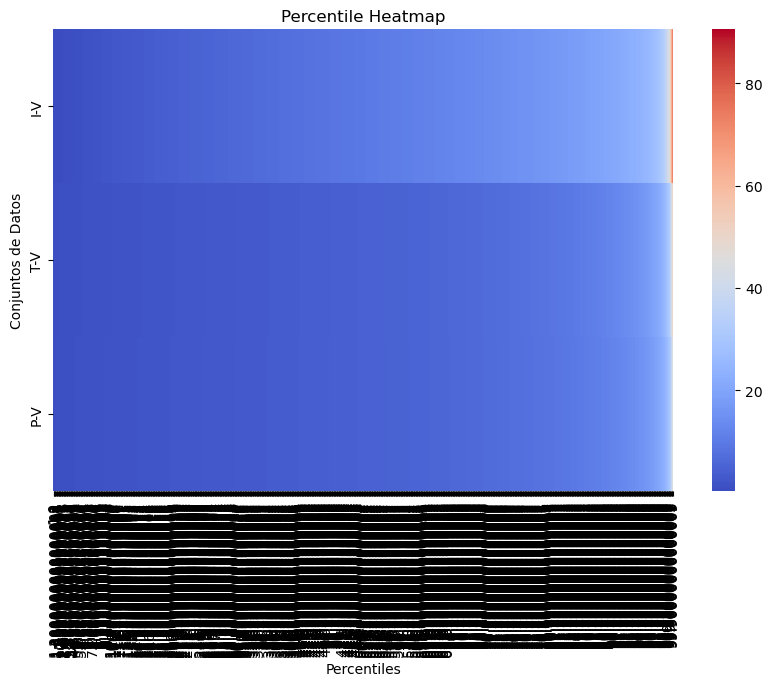

In [21]:
import seaborn as sns

percentiles_data = np.array([input_train_percentil, targets_train_percentil, preds_train_percentil])

plt.figure(figsize=(10, 6))
sns.heatmap(percentiles_data, cmap='coolwarm', xticklabels=percentiles, yticklabels=['I-V', 'T-V', 'P-V'])

# Añadir etiquetas y título
plt.xlabel('Percentiles')
plt.ylabel('Conjuntos de Datos')
plt.title('Percentile Heatmap')

pdf.savefig()

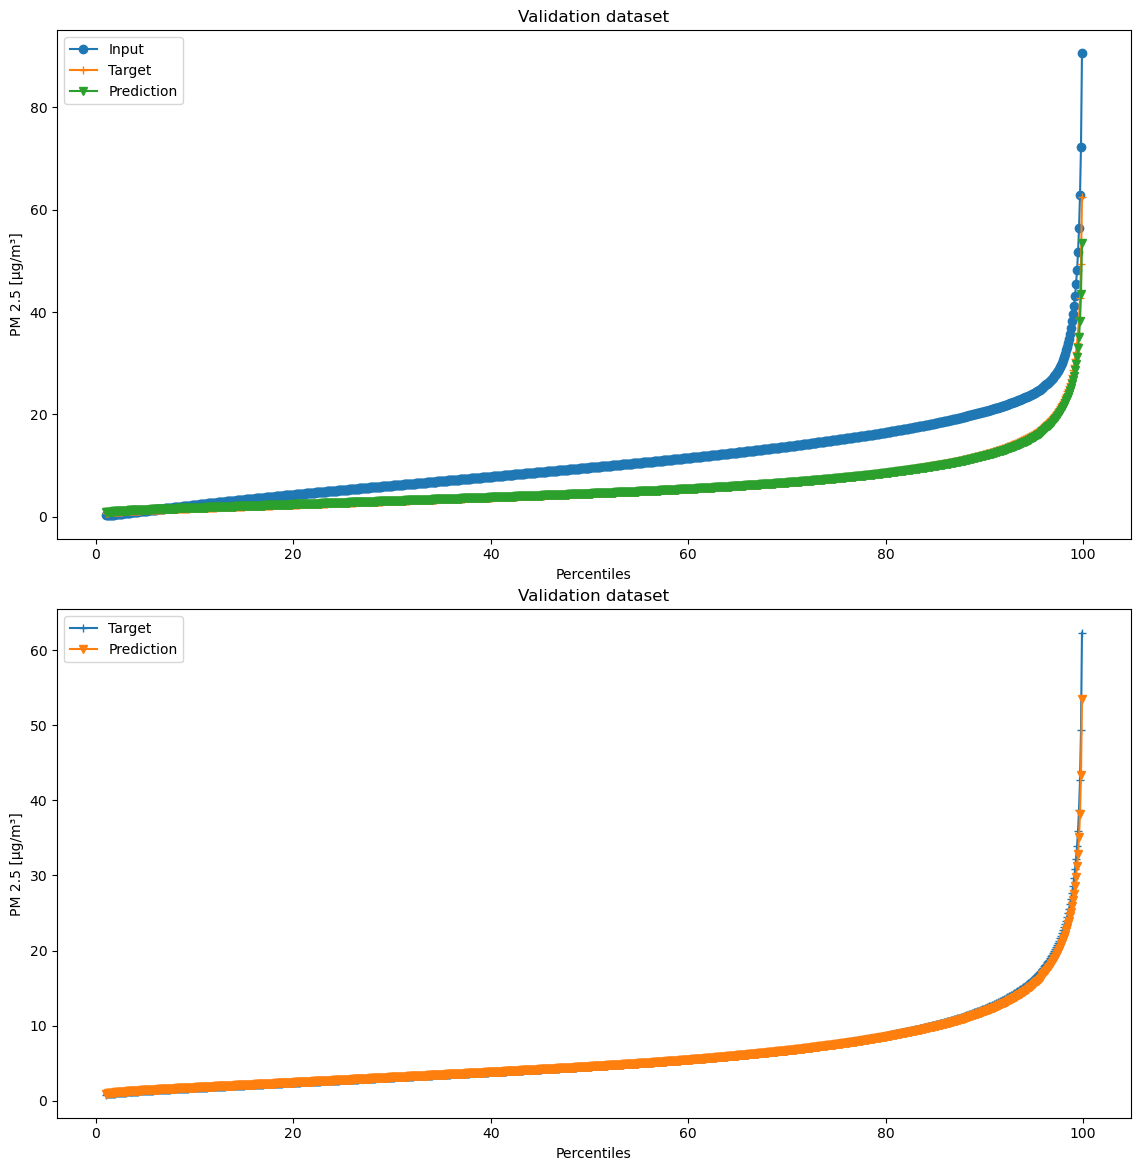

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))
fig.tight_layout(pad=3.0)

axes = axes.flatten()

axes[0].plot(percentiles, input_train_percentil, marker='o', linestyle='-', label='Input')
axes[0].plot(percentiles, targets_train_percentil, marker='+', linestyle='-', label='Target')
axes[0].plot(percentiles, preds_train_percentil, marker='v', linestyle='-', label='Prediction')
axes[0].set_title('Validation dataset')
axes[0].set_xlabel('Percentiles')
axes[0].set_ylabel('PM 2.5 [µg/m³]')
axes[0].legend()

axes[1].plot(percentiles, targets_train_percentil, marker='+', linestyle='-', label='Target')
axes[1].plot(percentiles, preds_train_percentil, marker='v', linestyle='-', label='Prediction')
axes[1].set_title('Validation dataset')
axes[1].set_xlabel('Percentiles')
axes[1].set_ylabel('PM 2.5 [µg/m³]')
axes[1].legend()

pdf.savefig()

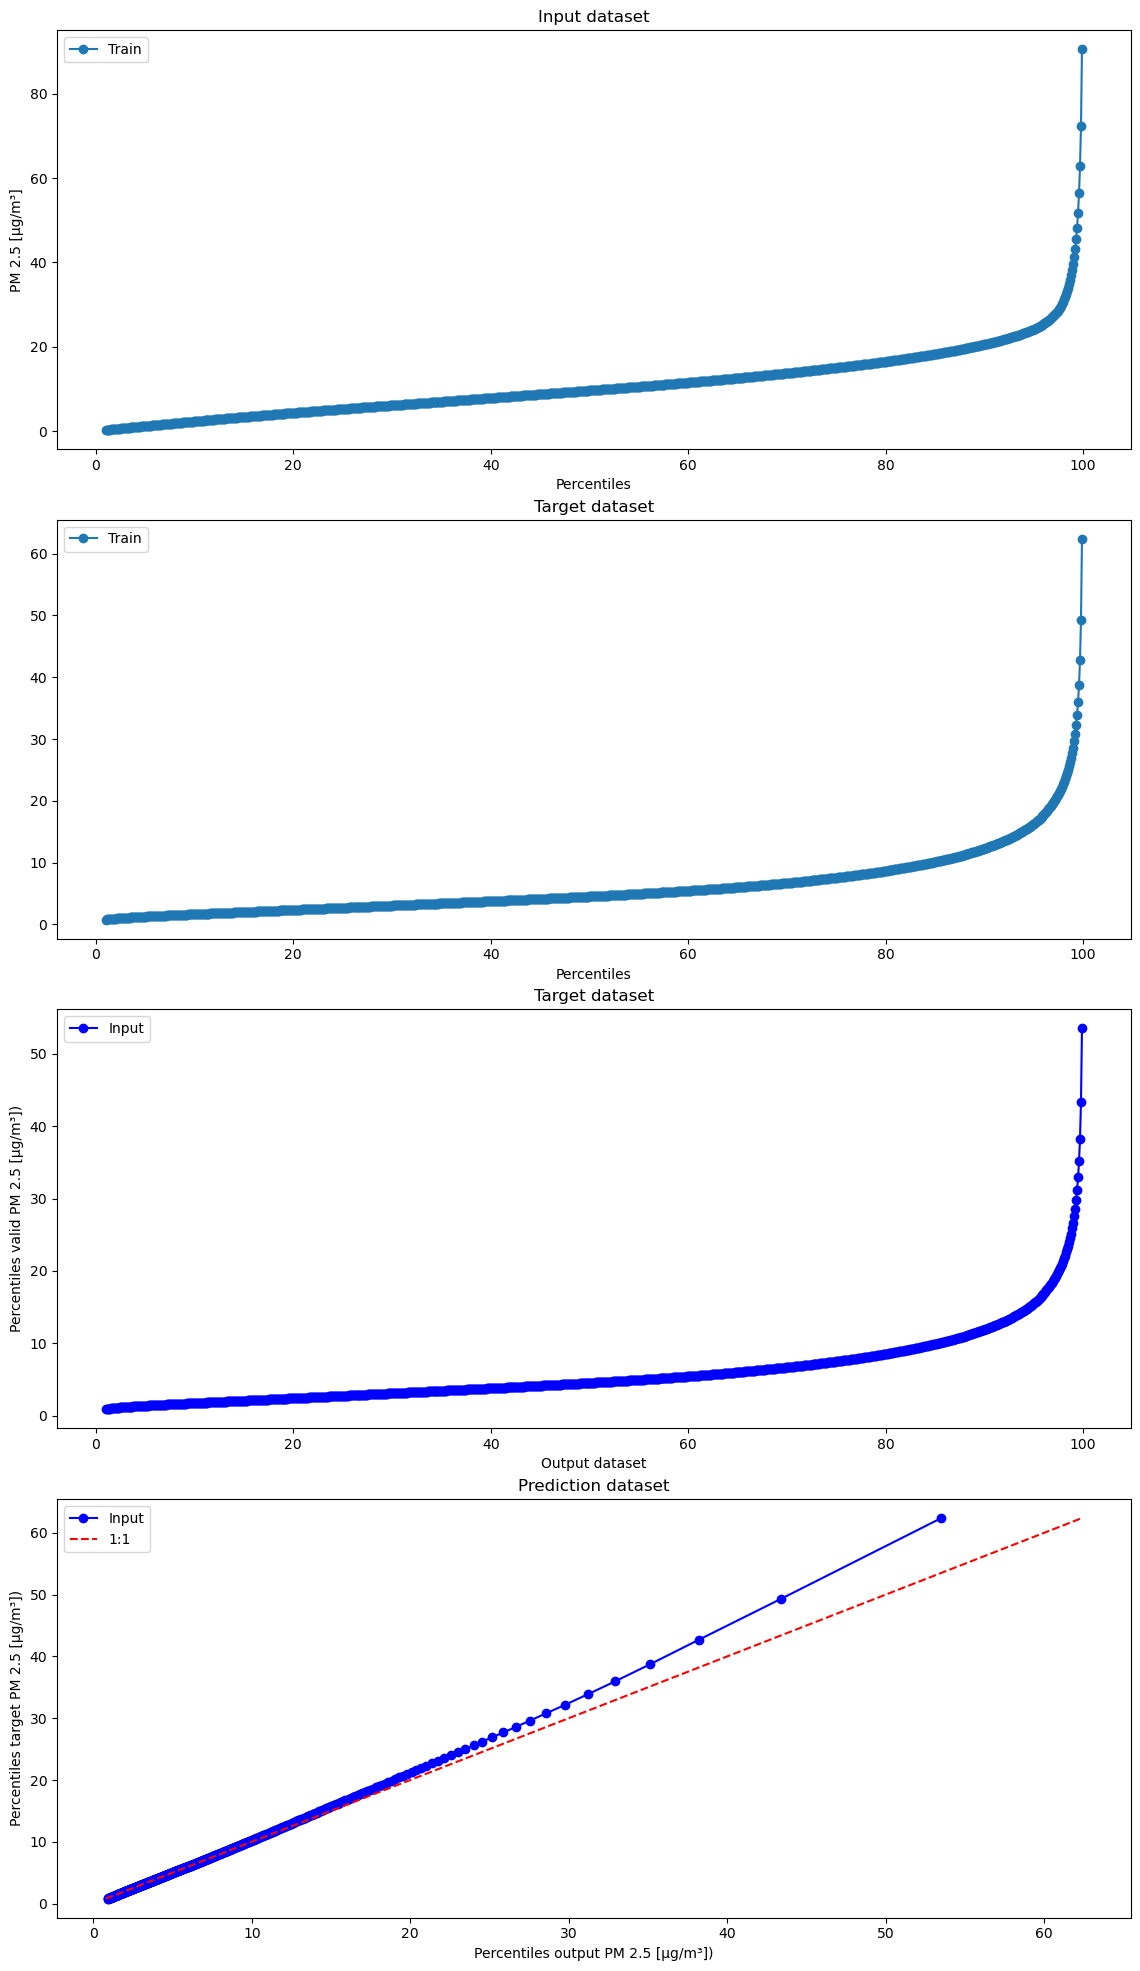

In [23]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 20))
fig.tight_layout(pad=3.0)

axes = axes.flatten()

axes[0].plot(percentiles, input_train_percentil, marker='o', linestyle='-', label='Train')
axes[0].set_title('Input dataset')
axes[0].set_xlabel('Percentiles')
axes[0].set_ylabel('PM 2.5 [µg/m³]')
axes[0].legend()

axes[1].plot(percentiles, targets_train_percentil, marker='o', linestyle='-', label='Train')
axes[1].set_title('Target dataset')
axes[1].set_xlabel('Percentiles')
axes[1].set_ylabel('')
axes[1].legend()

axes[2].plot(percentiles, preds_train_percentil, marker='o', linestyle='-', color='blue', label='Input')
axes[2].set_title('Target dataset')
axes[2].set_xlabel('Output dataset')
axes[2].set_ylabel('Percentiles valid PM 2.5 [µg/m³])')
axes[2].legend()

axes[3].plot(preds_train_percentil, targets_train_percentil, marker='o', linestyle='-', color='blue', label='Input')
axes[3].set_title('Prediction dataset')
axes[3].set_xlabel('Percentiles output PM 2.5 [µg/m³])')
axes[3].set_ylabel('Percentiles target PM 2.5 [µg/m³])')
min_val = min(preds_train_percentil.min(), targets_train_percentil.min())
max_val = max(preds_train_percentil.max(), targets_train_percentil.max())
axes[3].plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='1:1')

axes[3].legend()

pdf.savefig()

#### Spearsman correlation

In [55]:
stats_train = scipy.stats.spearmanr(targets_train_percentil, preds_train_percentil, axis=0, nan_policy='propagate')
stats_valid = scipy.stats.spearmanr(targets_valid_percentil, preds_valid_percentil, axis=0, nan_policy='propagate')

print('Training dataset:')
print('Correlation: ', stats_train[0])
print('p-value: ', stats_train[1])
print()
print('Validation dataset:')
print('Correlation: ', stats_valid[0])
print('p-value: ', stats_valid[1])

NameError: name 'targets_valid_percentil' is not defined

#### Pearson correlation

In [ ]:
stats_train = scipy.stats.pearsonr(targets_train_percentil, preds_train_percentil)
stats_valid = scipy.stats.pearsonr(targets_valid_percentil, preds_valid_percentil)

print('Training dataset:')
print('Correlation: ', stats_train[0])
print('p-value: ', stats_train[1])
print()
print('Validation dataset:')
print('Correlation: ', stats_valid[0])
print('p-value: ', stats_valid[1])

#### Plot 1M random data

In [ ]:
random_size = 1000000

print('Chossing {} random index for train data'.format(random_size))
train_index = np.random.choice(len(in_target_flat), size=random_size, replace=False)

print('Chossing {} random index for valid data')
valid_index = np.random.choice(len(in_output_flat), size=random_size, replace=False)

targets_train_flat_sample = in_target_flat[train_index]
preds_train_flat_sample = in_output_flat[train_index]
targets_valid_flat_sample = in_target_flat[valid_index]
preds_valid_flat_sample = in_output_flat[valid_index]

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
fig.tight_layout(pad=3.0)

print('Training data')
axes[0].scatter(targets_train_flat_sample, preds_train_flat_sample, color='blue', label='Train')
#axes[0].plot(target_valid_bins[:-1], target_valid_hist, color='red', label='Target Valid')
axes[0].set_title('Predictions-Target of Train dataset')
axes[0].set_xlabel('Target Wind Speed')
axes[0].set_ylabel('Prediction Wind Speed')
axes[0].legend()
#axes[0].text(20, 20, 'r² = {}'.format(np.round(stats_train[0], 5)), color='k',fontsize=12)
#axes[0].text(20, 18, 'p-value = {}'.format(np.round(stats_train[1], 5)), color='k',fontsize=12)

print('Validation data')
axes[1].scatter(targets_valid_flat_sample, preds_valid_flat_sample, color='blue', label='Valid')
#axes[1].plot(preds_valid_bins[:-1], preds_valid_hist, color='red', label='Pred Valid')
axes[1].set_title('Predictions-Target of Valid dataset')
axes[1].set_xlabel('Target Wind Speed')
axes[1].set_ylabel('Prediction Wind Speed')
axes[1].legend()
#axes[1].text(20, 20, 'r² = {}'.format(np.round(stats_valid[0], 5)), color='k',fontsize=12)
#axes[1].text(20,18, 'p-value = {}'.format(np.round(stats_valid[1], 5)), color='k',fontsize=12)

pdf.savefig()

plt.show()

In [ ]:
print('Train comparison:')
print()
print('MIN: ')
#print('Train-Input: ', np.round(input_train.min().item(), 4))
#print('Valid-Input: ', np.round(input_valid.min().item(), 4))
print('Train-Target: ', np.round(in_train_target.min().item(), 4))
print('Valid-Target: ', np.round(in_valid_target.min().item(), 4))
print('Train-Pred: ', np.round(preds_train.min().item(), 4))
print('Valid-Pred: ', np.round(preds_valid.min().item(), 4))
print('Train-Ratio: ', np.round((abs(preds_train.min() - in_train_target.min()) * 100 / in_train_target.min()).item(), 4), '%')
print('Valid-Ratio: ', np.round((abs(preds_valid.min() - in_valid_target.min()) * 100 / in_valid_target.min()).item(), 4), '%')
print()

In [ ]:
print('MAX: ')
#print('Train-Input: ', np.round(input_train.max().item(), 4))
#print('Valid-Input: ', np.round(input_valid.max().item(), 4))
print('Train-Target: ', np.round(in_train_target.max().item(), 4))
print('Valid-Target: ', np.round(in_valid_target.max().item(), 4))
print('Train-Pred: ', np.round(preds_train.max().item(), 4))
print('Valid-Pred: ', np.round(preds_valid.max().item(), 4))
print('Train-Ratio: ', np.round((abs(preds_train.max() - in_train_target.max()) * 100 / in_train_target.max()).item(), 4), '%')
print('Valid-Ratio: ', np.round((abs(preds_valid.max() - in_valid_target.max()) * 100 / in_valid_target.max()).item(), 4), '%')
print()

In [ ]:
print('MEAN: ')
#print('Train-Input: ', np.round(input_train.mean().item(), 4))
#print('Valid-Input: ', np.round(input_valid.mean().item(), 4))
print('Train-Target: ', np.round(in_train_target.mean().item(), 4))
print('Valid-Target: ', np.round(in_valid_target.mean().item(), 4))
print('Train-Pred: ', np.round(preds_train.mean().item(), 4))
print('Valid-Pred: ', np.round(preds_valid.mean().item(), 4))
print('Train-Ratio: ', np.round((abs(preds_train.mean() - in_train_target.mean()) * 100 / in_train_target.mean()).item(), 4), '%')
print('Valid-Ratio: ', np.round((abs(preds_valid.mean() - in_valid_target.mean()) * 100 / in_valid_target.mean()).item(), 4), '%')
print()

In [ ]:
print('STD: ')
#print('Train-Input: ', np.round(input_train.std().item(), 4))
#print('Valid-Input: ', np.round(input_valid.std().item(), 4))
print('Train-Target: ', np.round(in_train_target.std().item(), 4))
print('Valid-Target: ', np.round(in_valid_target.std().item(), 4))
print('Train-Pred: ', np.round(preds_train.std().item(), 4))
print('Valid-Pred: ', np.round(preds_valid.std().item(), 4))
print('Train-Ratio: ', np.round((abs(preds_train.std() - in_train_target.std()) * 100 / in_train_target.std()).item(), 4), '%')
print('Valid-Ratio: ', np.round((abs(preds_valid.std() - in_valid_target.std()) * 100 / in_valid_target.std()).item(), 4), '%')
print()

In [47]:
input_train_temp_mean = in_train_input.mean(dim=['latitude', 'longitude'])
targets_train_temp_mean = in_train_target.mean(dim=['latitude', 'longitude'])
preds_train_temp_mean = preds_train.mean(dim=['latitude', 'longitude'])

input_valid_temp_mean = in_valid_input.mean(dim=['latitude', 'longitude'])
targets_valid_temp_mean = in_valid_target.mean(dim=['latitude', 'longitude'])
preds_valid_temp_mean = preds_valid.mean(dim=['latitude', 'longitude'])


NameError: name 'targets_train_temp_mean' is not defined

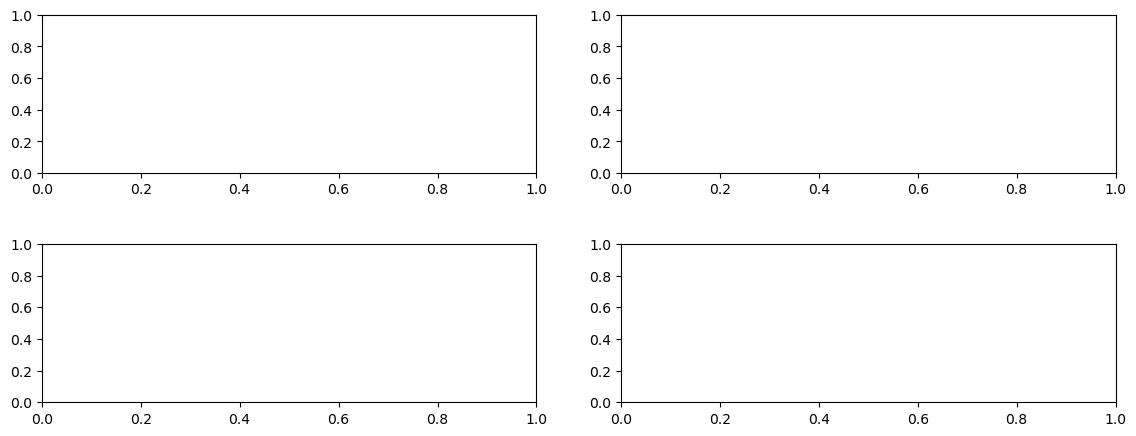

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 5))
fig.tight_layout(pad=3.0)

axes[0, 0].plot(targets_train_temp_mean["time"].values, targets_train_temp_mean.values, color='blue', label='Target')
axes[0, 0].plot(preds_train_temp_mean["time"].values, preds_train_temp_mean.values, color='red', label='Preds')
axes[0, 0].set_title('Training dataset')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Mean Wind Speed (m/s)')
axes[0, 0].legend()

axes[0, 1].plot(targets_valid_temp_mean["time"].values, targets_valid_temp_mean.values, color='blue', label='Target')
axes[0, 1].plot(preds_valid_temp_mean["time"].values, preds_valid_temp_mean.values, color='red', label='Preds')
axes[0, 1].set_title('Validation dataset')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Mean Wind Speed (m/s)')
axes[0, 1].legend()

axes[1, 0].plot(targets_train_temp_mean["time"].values, targets_train_temp_mean.values, color='blue', label='Train')
axes[1, 0].plot(targets_valid_temp_mean["time"].values, targets_valid_temp_mean.values, color='red', label='Valid')
axes[1, 0].set_title('Targets')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Mean Wind Speed (m/s)')
axes[1, 0].legend()

axes[1, 1].plot(preds_train_temp_mean["time"].values, preds_train_temp_mean.values, color='blue', label='Train')
axes[1, 1].plot(preds_valid_temp_mean["time"].values, preds_valid_temp_mean.values, color='red', label='Valid')
axes[1, 1].set_title('Predictions')
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Mean Wind Speed (m/s)')
axes[1, 1].legend()

pdf.savefig()

In [27]:
def Corr_RMSE(data1, data2): 

    assert data1.shape == data2.shape, "The prediction and target dimensions are different"

    # Remove nan values from data1 and data2
    mask = ~np.isnan(data1) & ~np.isnan(data2)
    data1_clean = data1[mask]
    data2_clean = data2[mask]

    corr_pixel_space = np.corrcoef(data1_clean, data2_clean)[0, 1]
    rmse_pixel_space = np.sqrt(np.mean(np.power((data1_clean - data2_clean), 2)))
                
    print('Corr: ', np.round(corr_pixel_space, 6))
    print('RMSE: ', np.round(rmse_pixel_space, 6))

    #results = {'Corr': corr_pixel_space, 'RMSE': rmse_pixel_space}

    return corr_pixel_space, rmse_pixel_space

In [28]:
corr_train, rmse_train = Corr_RMSE(targets_train_temp_mean.values, preds_train_temp_mean.values)
print()
corr_valid, rmse_valid = Corr_RMSE(targets_valid_temp_mean.values, preds_valid_temp_mean.values)

NameError: name 'targets_train_temp_mean' is not defined

In [29]:
stats_train = scipy.stats.pearsonr(targets_train_temp_mean, preds_train_temp_mean)
stats_valid = scipy.stats.pearsonr(targets_valid_temp_mean, preds_valid_temp_mean)

print('Training dataset:')
print('Correlation: ', stats_train[0])
print('p-value: ', stats_train[1])
print()
print('Validation dataset:')
print('Correlation: ', stats_valid[0])
print('p-value: ', stats_valid[1])

NameError: name 'targets_train_temp_mean' is not defined

In [30]:
stats_train = scipy.stats.spearmanr(targets_train_temp_mean, preds_train_temp_mean, axis=0, nan_policy='propagate')
stats_valid = scipy.stats.spearmanr(targets_valid_temp_mean, preds_valid_temp_mean, axis=0, nan_policy='propagate')

print('Training dataset:')
print('Correlation: ', stats_train[0])
print('p-value: ', stats_train[1])
print()
print('Validation dataset:')
print('Correlation: ', stats_valid[0])
print('p-value: ', stats_valid[1])

NameError: name 'targets_train_temp_mean' is not defined

In [53]:
epochs = []

#input_train_min = []
#input_train_max = []
#input_train_mean = []
#input_train_std = []

#targets_train_min = []
#targets_train_max = []
#targets_train_mean = []
#targets_train_std = []

preds_train_min = []
preds_train_max = []
preds_train_mean = []
preds_train_std = []

#input_valid_min = []
#input_valid_max = []
#input_valid_mean = []
#input_valid_std = []

#targets_valid_min = []
#targets_valid_max = []
#targets_valid_mean = []
#targets_valid_std = []

preds_valid_min = []
preds_valid_max = []
preds_valid_mean = []
preds_valid_std = []

In [ ]:
split = ['train', 'valid']

print('Calculating previous train statistics')
targets_train_min = in_train_target.min().item()
targets_train_max = in_train_target.max().item()
targets_train_mean = in_train_target.mean().item()
targets_train_std = in_train_target.std().item()

print('Calculating previous valid statistics')
targets_valid_min = in_valid_target.min().item()
targets_valid_max = in_valid_target.max().item()
targets_valid_mean = in_valid_target.mean().item()
targets_valid_std = in_valid_target.std().item()

print('Calculating over predictions')
for epoch in range(20, 120, 20):

    print('epoch: ', epoch)

    epochs.append(epoch)
    
    train_name = 'pred_train_epoch_{}.nc'.format(epoch)
    valid_name = 'pred_valid_epoch_{}.nc'.format(epoch)

    ds_train = xr.open_dataset(os.path.join(path_out, split[0], train_name))
    ds_valid = xr.open_dataset(os.path.join(path_out, split[1], valid_name))
    #spain_mask = xr.open_dataset(os.path.join(path_dir, 'ERA_2021_with_spain_mask.nc'))["mask_spain"]

    #input_train = ds_train["inputs"]
    #targets_train = ds_train["targets"]
    preds_train = ds_train["preds"]

    #input_valid = ds_valid["inputs"]
    #targets_valid = ds_valid["targets"]
    preds_valid = ds_valid["preds"]

    #input_train_min.append(input_train.min().item())
    #input_train_max.append(input_train.max().item())
    #input_train_mean.append(input_train.mean().item())
    #input_train_std.append(input_train.std().item())

    #targets_train_min.append(targets_train.min().item())
    #targets_train_max.append(targets_train.max().item())
    #targets_train_mean.append(targets_train.mean().item())
    #targets_train_std.append(targets_train.std().item())

    preds_train_min.append(preds_train.min().item())
    preds_train_max.append(preds_train.max().item())
    preds_train_mean.append(preds_train.mean().item())
    preds_train_std.append(preds_train.std().item())

    #input_valid_min.append(input_valid.min().item())
    #input_valid_max.append(input_valid.max().item())
    #input_valid_mean.append(input_valid.mean().item())
    #input_valid_std.append(input_valid.std().item())

    #targets_valid_min.append(targets_valid.min().item())
    #targets_valid_max.append(targets_valid.max().item())
    #targets_valid_mean.append(targets_valid.mean().item())
    #targets_valid_std.append(targets_valid.std().item())

    preds_valid_min.append(preds_valid.min().item())
    preds_valid_max.append(preds_valid.max().item())
    preds_valid_mean.append(preds_valid.mean().item())
    preds_valid_std.append(preds_valid.std().item())


In [ ]:
stats_pred_train = {
         'min': preds_train_min, 'max': preds_train_max, 
         'mean': preds_train_mean, 'std': preds_train_std, 
        }

stats_pred_valid = {
         'min': preds_valid_min, 'max': preds_valid_max, 
         'mean': preds_valid_mean, 'std': preds_valid_std, 
        }

stats_true_train = {
         'min': targets_train_min, 'max': targets_train_max, 
         'mean': targets_train_mean, 'std': targets_train_std, 
        }

stats_true_valid = {
         'min': targets_valid_min, 'max': targets_valid_max, 
         'mean': targets_valid_mean, 'std': targets_valid_std, 
        }

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 15))
fig.tight_layout(pad=3.0)

# Crear histogramas para cada epoch
for i, (key, data) in enumerate(stats_pred_train.items()):
    axes[i].plot(epochs, data, color='blue', label='Pred Train')
    axes[i].plot(epochs, stats_pred_valid[key], color='red', label='Pred Valid')
    axes[i].hlines(stats_true_train[key], xmin=min(epochs), xmax=max(epochs), colors='blue', linestyles='dashed', label='Target Train')
    axes[i].hlines(stats_true_valid[key], xmin=min(epochs), xmax=max(epochs), colors='red', linestyles='dashed', label='Target Valid')
    axes[i].set_title(f'{key} vs epochs')
    axes[i].set_xlabel('Epochs')
    axes[i].set_ylabel(f'{key}')
    axes[i].legend()

pdf.savefig()

plt.show()

In [ ]:
stats_pred = {
         'train_min': preds_train_min, 'train_max': preds_train_max, 
         'train_mean': preds_train_mean, 'train_std': preds_train_std, 
         'valid_min': preds_valid_min, 'valid_max': preds_valid_max, 
         'valid_mean': preds_valid_mean, 'valid_std': preds_valid_std, 
        }

stats_true = {
         'train_min': targets_train_min, 'train_max': targets_train_max, 
         'train_mean': targets_train_mean, 'train_std': targets_train_std, 
         'valid_min': targets_valid_min, 'valid_max': targets_valid_max, 
         'valid_mean': targets_valid_mean, 'valid_std': targets_valid_std, 
        }

In [ ]:
fig, axes = plt.subplots(nrows=len(stats_pred), ncols=1, figsize=(8, 30))
fig.tight_layout(pad=3.0)

# Crear histogramas para cada epoch
for i, (key, data) in enumerate(stats_pred.items()):
    ax = axes[i]
    ax.plot(epochs, data, label='Prediction')
    ax.hlines(stats_true[key], xmin=min(epochs), xmax=max(epochs), colors='r', linestyles='dashed', label='Target')
    ax.set_title(f'{key} vs epochs')
    ax.set_xlabel('Epochs')
    ax.set_ylabel(f'{key}')
    ax.legend()

pdf.savefig()

plt.show()

In [ ]:
pdf.close()